# Data analytics of EXI Dataset

- Data collected from https://european-investor-exchange.com/en/trade-list


## Step 0 - Familiarisation with data
- read csv files of october
- basis statistics
- descriptive statistics
- basic visuals

## Step 1 - Data Cleaning
- Check and summarize missing values per column using combined_df.isnull().sum().
- Drop duplicates with combined_df.drop_duplicates(inplace=True).
- Convert data types:
- Ensure Quantity and Unit Price are numeric.
- Convert Trading day & Trading time UTC to datetime.
- Standardize text-based columns such as Side and Price Currency by stripping spaces and converting to uppercase.

## Step 2 - Feature Engineering
- Add a new column: Trade Amount = Quantity × Unit Price.
- Extract datetime features: date, time, hour, day of week.
- Create log-transformed or normalized columns for skewed variables if relevant to modeling or visualization.

## Step 3 - Exploratory Data Analysis (EDA)
- Plot data distributions for Unit Price, Quantity, and Trade Amount.
- Explore relationships like Quantity vs Unit Price and Trade Amount vs Side.
- Identify time-based trading patterns — daily or hourly volumes and price trends.
- Analyze top instruments and venues by total trade quantity or value.

## Step 4 - Outlier Detection
- Use boxplots or z-score thresholds to highlight outliers in Quantity and Unit Price.
- Optionally apply the interquartile range (IQR) method to filter extreme values.
- Visualize outlier patterns across Side or Venue Identifier.

## Step 5 - Venue & Instrument Analysis
- Aggregate by Venue Identifier and Instrument Identifier to observe trading concentration.
- Identify instruments or venues with the highest variance in price or volume.
- Visualize via bar charts or pie charts the proportion of trading volume by venue/instrument.

## Step 6 - Model Preparation
- Select relevant features — numeric variables (e.g., Trade Amount, Quantity) and categorical ones (Side, Venue Identifier).
- Encode categorical variables using one-hot encoding.
- Address data imbalance or skew using sampling or scaling.
- Split into training and testing sets for modeling.

In [35]:
# import basis libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# List all CSV files in current directory
csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]
print(csv_files)

['Official_Trade_List_2025-10-01.csv', 'Official_Trade_List_2025-10-02.csv', 'Official_Trade_List_2025-10-03.csv', 'Official_Trade_List_2025-10-06.csv', 'Official_Trade_List_2025-10-07.csv', 'Official_Trade_List_2025-10-08.csv', 'Official_Trade_List_2025-10-09.csv', 'Official_Trade_List_2025-10-10.csv', 'Official_Trade_List_2025-10-13.csv', 'Official_Trade_List_2025-10-14.csv', 'Official_Trade_List_2025-10-15.csv', 'Official_Trade_List_2025-10-16.csv', 'Official_Trade_List_2025-10-17.csv', 'Official_Trade_List_2025-10-20.csv', 'Official_Trade_List_2025-10-21.csv', 'Official_Trade_List_2025-10-22.csv', 'Official_Trade_List_2025-10-23.csv', 'Official_Trade_List_2025-10-24.csv']


In [15]:
# read single file to see the schema of the csv file
df = pd.read_csv('Official_Trade_List_2025-10-01.csv')

# View the first five rows
print(df.head(5))


  Trading day & Trading time UTC Instrument Identifier  Quantity  Unit Price  \
0       2025-10-01T05:30:00.424Z          GB00BMHVL512         5      31.080   
1       2025-10-01T05:30:00.590Z          JP3224200000        19      54.180   
2       2025-10-01T05:30:00.581Z          IE00BK5BQT80         2     139.220   
3       2025-10-01T05:30:00.624Z          DE0002635281        19      20.380   
4       2025-10-01T05:30:00.596Z          JP3866800000        53       9.184   

  Price Currency Venue Identifier Side  
0            EUR             HAND    B  
1            EUR             HAND    B  
2            EUR             HAND    B  
3            EUR             HAND    B  
4            EUR             HAND    B  


In [16]:
# List all CSV files in the current directory
csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]

# Read and combine them into one DataFrame
if csv_files:  # Check if any CSV files exist
    combined_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
    print("Combined DataFrame shape:", combined_df.shape)
else:
    print("No CSV files found in the current directory.")


Combined DataFrame shape: (824342, 7)


In [6]:
combined_df.head(5)

,Trading day & Trading time UTC,Instrument Identifier,Quantity,Unit Price,Price Currency,Venue Identifier,Side
0,2025-10-01T05:30:00.424Z,GB00BMHVL512,5,31.080,EUR,HAND,B
1,2025-10-01T05:30:00.590Z,JP3224200000,19,54.180,EUR,HAND,B
2,2025-10-01T05:30:00.581Z,IE00BK5BQT80,2,139.220,EUR,HAND,B
3,2025-10-01T05:30:00.624Z,DE0002635281,19,20.380,EUR,HAND,B
4,2025-10-01T05:30:00.596Z,JP3866800000,53,9.184,EUR,HAND,B


# Basis Overview
- data types
- numerical distributions
- missing values.
- trade price ranges
- the most frequently traded instruments

In [9]:
combined_df.columns

Index(['Trading day & Trading time UTC', 'Instrument Identifier', 'Quantity',
       'Unit Price', 'Price Currency', 'Venue Identifier', 'Side'],
      dtype='object')

In [18]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824342 entries, 0 to 824341
Data columns (total 7 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Trading day & Trading time UTC  824342 non-null  object 
 1   Instrument Identifier           824342 non-null  object 
 2   Quantity                        824342 non-null  int64  
 3   Unit Price                      824342 non-null  float64
 4   Price Currency                  824342 non-null  object 
 5   Venue Identifier                824342 non-null  object 
 6   Side                            824342 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 44.0+ MB


In [19]:
print(combined_df.describe())

           Quantity     Unit Price
count  8.243420e+05  824342.000000
mean   1.531329e+02     130.124100
std    2.526661e+03     328.482551
min    1.000000e+00       0.000200
25%    3.000000e+00      13.265000
50%    1.000000e+01      47.050000
75%    4.700000e+01     138.187500
max    1.111111e+06  136600.000000


In [20]:
print(combined_df.isnull().sum())

Trading day & Trading time UTC    0
Instrument Identifier             0
Quantity                          0
Unit Price                        0
Price Currency                    0
Venue Identifier                  0
Side                              0
dtype: int64


### Descriptive statistics
-  trade price ranges
- the most frequently traded instruments.

In [21]:
print(combined_df.groupby('Side')['Unit Price'].describe())

         count        mean         std     min        25%    50%        75%  \
Side                                                                          
B     525548.0  122.831898  276.026001  0.0005  12.701625  45.10  122.79225   
M      21749.0  176.788243  397.406582  0.0030  11.450000  46.00  152.00000   
S     277045.0  140.293940  404.663968  0.0002  15.000000  50.99  152.98000   

           max  
Side            
B      14490.0  
M       8250.0  
S     136600.0  


In [23]:
print(combined_df['Instrument Identifier'].value_counts().head(5))

US26740W1099    16740
US67066G1040    16649
US0231351067    13734
AU000000DRO2    12689
US0079031078    12201
Name: Instrument Identifier, dtype: int64


### Key Visualizations

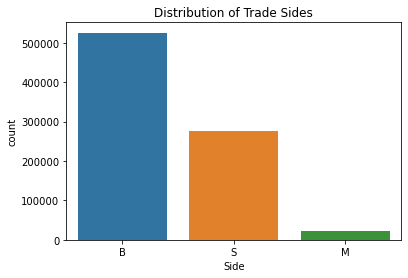

In [24]:
sns.countplot(data=combined_df, x='Side')
plt.title('Distribution of Trade Sides')
plt.show()


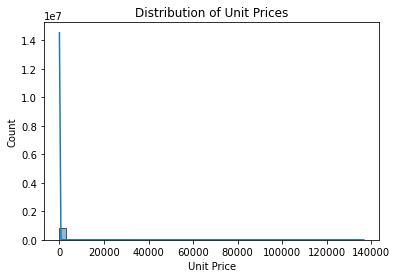

In [26]:
sns.histplot(data=combined_df, x='Unit Price', bins=50, kde=True)
plt.title('Distribution of Unit Prices')
plt.show()

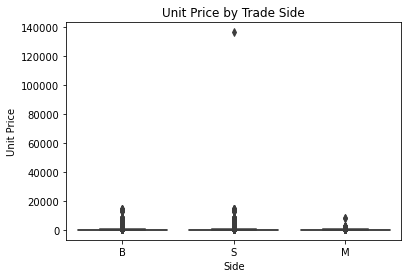

In [27]:
sns.boxplot(data=combined_df, x='Side', y='Unit Price')
plt.title('Unit Price by Trade Side')
plt.show()

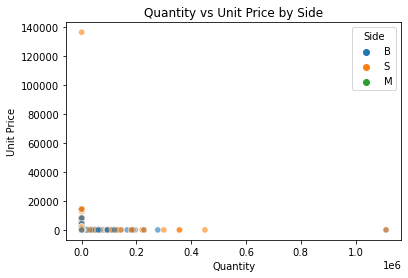

In [28]:
sns.scatterplot(data=combined_df, x='Quantity', y='Unit Price', hue='Side', alpha=0.6)
plt.title('Quantity vs Unit Price by Side')
plt.show()


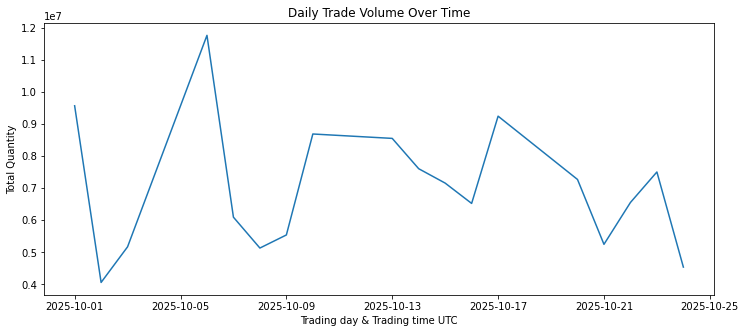

In [29]:
combined_df['Trading day & Trading time UTC'] = pd.to_datetime(combined_df['Trading day & Trading time UTC'])
daily_volume = combined_df.groupby(combined_df['Trading day & Trading time UTC'].dt.date)['Quantity'].sum()

daily_volume.plot(kind='line', figsize=(12,5), title='Daily Trade Volume Over Time')
plt.ylabel('Total Quantity')
plt.show()

## Step-1 Data Cleaning
How this helps:

- Converts all types correctly for quantitative and time-series analysis.
- Normalizes categorical text fields.
- Eliminates duplicates and reveals missing data accurately.

In [30]:
# 1. Check and summarize missing values per column
print(combined_df.isnull().sum())

# 2. Drop duplicate rows
combined_df.drop_duplicates(inplace=True)

# 3. Convert data types
combined_df['Trading day & Trading time UTC'] = pd.to_datetime(combined_df['Trading day & Trading time UTC'], errors='coerce')
combined_df['Quantity'] = pd.to_numeric(combined_df['Quantity'], errors='coerce')
combined_df['Unit Price'] = pd.to_numeric(combined_df['Unit Price'], errors='coerce')

# 4. Standardize text-based columns
combined_df['Side'] = combined_df['Side'].str.strip().str.upper()
combined_df['Price Currency'] = combined_df['Price Currency'].str.strip().str.upper()

# 5. Summary after cleaning
print('Shape after cleaning:', combined_df.shape)
print('Remaining null values:', combined_df.isnull().sum())


Trading day & Trading time UTC    0
Instrument Identifier             0
Quantity                          0
Unit Price                        0
Price Currency                    0
Venue Identifier                  0
Side                              0
dtype: int64
Shape after cleaning: (814987, 7)
Remaining null values: Trading day & Trading time UTC    0
Instrument Identifier             0
Quantity                          0
Unit Price                        0
Price Currency                    0
Venue Identifier                  0
Side                              0
dtype: int64


## Step-2 Feature Engineering

- The new Trade Amount column captures trade value and will be key in later analyses.
- Extracted date/time fields allow temporal pattern detection (hourly, daily, weekday trends).
- Log-transformed features help stabilize variance in price and quantity during visualization and modeling.

In [31]:
# 1. Create new derived column: Trade Amount (Quantity × Unit Price)
combined_df['Trade Amount'] = combined_df['Quantity'] * combined_df['Unit Price']

# 2. Extract datetime components for time-based analysis
combined_df['Trade Date'] = combined_df['Trading day & Trading time UTC'].dt.date
combined_df['Trade Hour'] = combined_df['Trading day & Trading time UTC'].dt.hour
combined_df['Trade Weekday'] = combined_df['Trading day & Trading time UTC'].dt.day_name()
combined_df['Trade Month'] = combined_df['Trading day & Trading time UTC'].dt.month

# 3. (Optional) Log-transform skewed numeric features for better visualization later
import numpy as np
for col in ['Quantity', 'Unit Price', 'Trade Amount']:
    combined_df[f'log_{col}'] = np.log1p(combined_df[col])

# 4. Quick verification summary
print(combined_df[['Quantity', 'Unit Price', 'Trade Amount']].describe())
print(combined_df[['Trade Date', 'Trade Hour', 'Trade Weekday', 'Trade Month']].head())


           Quantity     Unit Price  Trade Amount
count  8.149870e+05  814987.000000  8.149870e+05
mean   1.540494e+02     129.230254  2.337043e+03
std    2.540202e+03     326.898636  2.074727e+04
min    1.000000e+00       0.000200  1.400000e-03
25%    3.000000e+00      13.265000  2.221725e+02
50%    1.000000e+01      46.995000  4.952400e+02
75%    4.700000e+01     137.640000  1.503000e+03
max    1.111111e+06  136600.000000  9.894333e+06
   Trade Date  Trade Hour Trade Weekday  Trade Month
0  2025-10-01           5     Wednesday           10
1  2025-10-01           5     Wednesday           10
2  2025-10-01           5     Wednesday           10
3  2025-10-01           5     Wednesday           10
4  2025-10-01           5     Wednesday           10


In [32]:
combined_df.head(3)

,Trading day & Trading time UTC,Instrument Identifier,Quantity,Unit Price,Price Currency,Venue Identifier,Side,Trade Amount,Trade Date,Trade Hour,Trade Weekday,Trade Month,log_Quantity,log_Unit Price,log_Trade Amount
0,2025-10-01 05:30:00.424000+00:00,GB00BMHVL512,5,31.08,EUR,HAND,B,155.40,2025-10-01,5,Wednesday,10,1.791759,3.468233,5.052417
1,2025-10-01 05:30:00.590000+00:00,JP3224200000,19,54.18,EUR,HAND,B,1029.42,2025-10-01,5,Wednesday,10,2.995732,4.010601,6.937722
2,2025-10-01 05:30:00.581000+00:00,IE00BK5BQT80,2,139.22,EUR,HAND,B,278.44,2025-10-01,5,Wednesday,10,1.098612,4.943213,5.632788


## Step-3 EDA
#### What this step reveals:

- Numerical summaries for trade prices, quantities, and total value.
- Top traded instruments to identify liquidity concentration.
- Side distribution (Buy/Sell ratio).
- Temporal patterns — daily and hourly trading activity.
- Relationships between trade quantity and unit price.


[INFO] Descriptive summary of key numeric columns:
           Quantity     Unit Price  Trade Amount
count  8.149870e+05  814987.000000  8.149870e+05
mean   1.540494e+02     129.230254  2.337043e+03
std    2.540202e+03     326.898636  2.074727e+04
min    1.000000e+00       0.000200  1.400000e-03
25%    3.000000e+00      13.265000  2.221725e+02
50%    1.000000e+01      46.995000  4.952400e+02
75%    4.700000e+01     137.640000  1.503000e+03
max    1.111111e+06  136600.000000  9.894333e+06

[INFO] Top 10 most traded instruments by total quantity:
Instrument Identifier
AU000000DRO2    4772523
LU0411075020    3512064
AU000000ARU5    3396103
FR001400PDG8    2891140
CA92865M1023    2567906
US08862E1091    2517511
LU2903252349    2482372
US72919P2020    1790996
IE00B8GKPP93    1775791
FR001400H2X4    1741004
Name: Quantity, dtype: int64

[INFO] Trade side distribution counts:
B    524942
S    276774
M     13271
Name: Side, dtype: int64


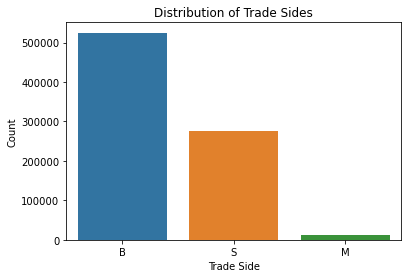

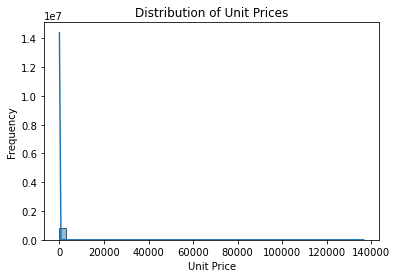

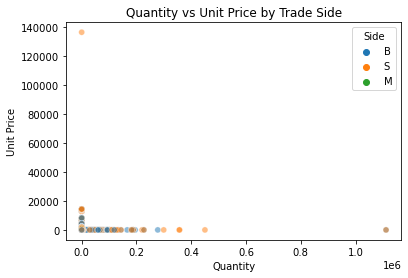

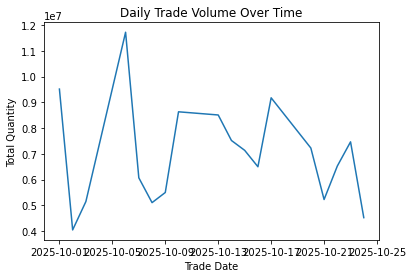

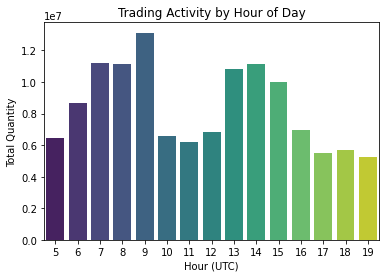

In [33]:
# 1. Statistical summaries
print("\n[INFO] Descriptive summary of key numeric columns:")
print(combined_df[['Quantity', 'Unit Price', 'Trade Amount']].describe())

print("\n[INFO] Top 10 most traded instruments by total quantity:")
print(combined_df.groupby('Instrument Identifier')['Quantity'].sum()
      .sort_values(ascending=False).head(10))

print("\n[INFO] Trade side distribution counts:")
print(combined_df['Side'].value_counts())

# 2. Visualizations

# Distribution of trade sides
sns.countplot(data=combined_df, x='Side')
plt.title('Distribution of Trade Sides')
plt.xlabel('Trade Side')
plt.ylabel('Count')
plt.show()

# Distribution of unit prices
sns.histplot(data=combined_df, x='Unit Price', bins=50, kde=True)
plt.title('Distribution of Unit Prices')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.show()

# Quantity vs Unit Price by Side
sns.scatterplot(data=combined_df, x='Quantity', y='Unit Price', hue='Side', alpha=0.5)
plt.title('Quantity vs Unit Price by Trade Side')
plt.xlabel('Quantity')
plt.ylabel('Unit Price')
plt.show()

# Daily trade volume trends
daily_volume = combined_df.groupby('Trade Date')['Quantity'].sum().reset_index()
sns.lineplot(data=daily_volume, x='Trade Date', y='Quantity')
plt.title('Daily Trade Volume Over Time')
plt.xlabel('Trade Date')
plt.ylabel('Total Quantity')
plt.show()

# Hourly trade activity trends
hourly_volume = combined_df.groupby('Trade Hour')['Quantity'].sum().reset_index()
sns.barplot(data=hourly_volume, x='Trade Hour', y='Quantity', palette='viridis')
plt.title('Trading Activity by Hour of Day')
plt.xlabel('Hour (UTC)')
plt.ylabel('Total Quantity')
plt.show()


## Step-4: OutliersDetection
- Boxplots quickly highlight extreme outliers visually.
- The IQR method identifies and removes statistically extreme points while preserving most of the valid observations.
- Comparing statistics before and after filtering quantifies the effect of outlier handling on Quantity and Unit Price.


[INFO] Visualizing Unit Price outliers using boxplot:


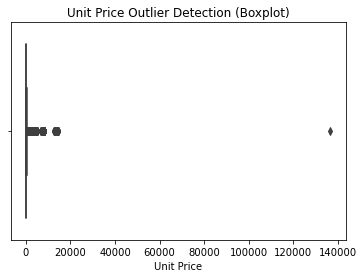


[INFO] Visualizing Quantity outliers using boxplot:


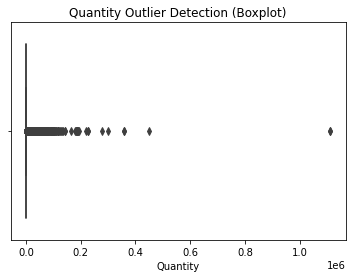


[INFO] Number of Quantity outliers detected: 108893
[INFO] Number of Unit Price outliers detected: 62689

[INFO] Summary statistics BEFORE filtering outliers:
           Quantity     Unit Price
count  8.149870e+05  814987.000000
mean   1.540494e+02     129.230254
std    2.540202e+03     326.898636
min    1.000000e+00       0.000200
25%    3.000000e+00      13.265000
50%    1.000000e+01      46.995000
75%    4.700000e+01     137.640000
max    1.111111e+06  136600.000000

[INFO] Summary statistics AFTER removing outliers:
            Quantity     Unit Price
count  643612.000000  643612.000000
mean       20.051739      77.735879
std        25.924893      75.682661
min         1.000000       0.000200
25%         3.000000      18.542000
50%         9.000000      49.545000
75%        26.000000     115.240000
max       113.000000     324.200000
[INFO] New dataset shape after outlier removal: (643612, 15)


In [34]:
# 1. Visual examination of outliers using boxplots
print("\n[INFO] Visualizing Unit Price outliers using boxplot:")
sns.boxplot(data=combined_df, x='Unit Price')
plt.title('Unit Price Outlier Detection (Boxplot)')
plt.xlabel('Unit Price')
plt.show()

print("\n[INFO] Visualizing Quantity outliers using boxplot:")
sns.boxplot(data=combined_df, x='Quantity')
plt.title('Quantity Outlier Detection (Boxplot)')
plt.xlabel('Quantity')
plt.show()

# 2. Statistical detection using the IQR method
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers

quantity_outliers = detect_outliers_iqr(combined_df['Quantity'])
price_outliers = detect_outliers_iqr(combined_df['Unit Price'])

print(f"\n[INFO] Number of Quantity outliers detected: {len(quantity_outliers)}")
print(f"[INFO] Number of Unit Price outliers detected: {len(price_outliers)}")

# 3. Statistical comparison before and after filtering
print("\n[INFO] Summary statistics BEFORE filtering outliers:")
print(combined_df[['Quantity', 'Unit Price']].describe())

# Optionally remove outliers for clean analysis
cleaned_df = combined_df[~combined_df['Quantity'].isin(quantity_outliers)]
cleaned_df = cleaned_df[~cleaned_df['Unit Price'].isin(price_outliers)]

print("\n[INFO] Summary statistics AFTER removing outliers:")
print(cleaned_df[['Quantity', 'Unit Price']].describe())
print(f"[INFO] New dataset shape after outlier removal: {cleaned_df.shape}")


## Step-5 Venue and instrument analysis


[INFO] Calculating aggregated trading metrics per venue:

[INFO] Top 10 venues by total trade amount:
                  Quantity  Trade Amount  Instrument Identifier
Venue Identifier                                               
HAND              12390029  6.130134e+08                   8319
undefined           262168  1.415614e+07                   1791
HANC                253343  1.154057e+07                     20


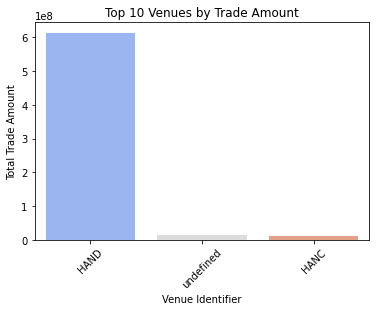


[INFO] Calculating key trade statistics per instrument:

[INFO] Top 10 instruments by total trade amount:
                       Quantity  Trade Amount  Unit Price  Venue Identifier
Instrument Identifier                                                      
US67066G1040             198515  3.159515e+07  159.211466                 2
US0079031078             139581  2.605516e+07  187.497773                 2
US0231351067             132363  2.488802e+07  187.748146                 2
IE00B4L5Y983             128110  1.392948e+07  108.710674                 2
IE00B4ND3602             161974  1.110323e+07   68.489085                 2
IE00BK5BQT80              78409  1.107433e+07  141.227817                 2
US26740W1099             360294  1.092046e+07   30.537828                 2
US02079K3059              46292  9.821708e+06  211.905911                 2
US69608A1088              54543  8.438704e+06  154.603141                 2
US0378331005              36561  8.015045e+06  219.023809

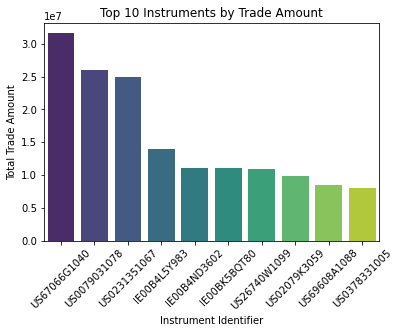


[INFO] Analyzing trade side distributions per venue:
Side                   B      M       S
Venue Identifier                       
HANC                6631     97    4010
HAND              405415  10289  204333
undefined           8401      0    4436


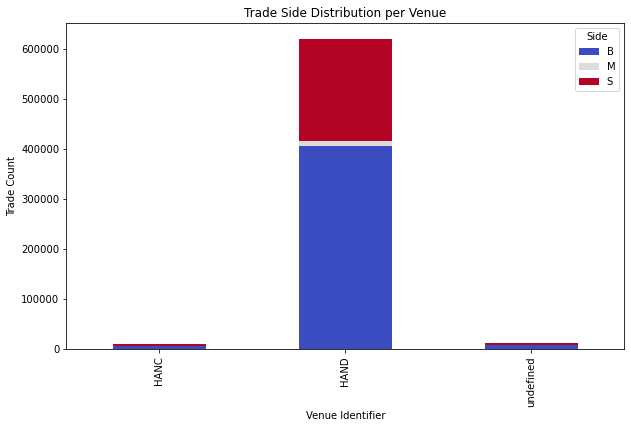

In [36]:
# 1. Aggregated metrics per venue
print("\n[INFO] Calculating aggregated trading metrics per venue:")
venue_summary = cleaned_df.groupby('Venue Identifier').agg({
    'Quantity': 'sum',
    'Trade Amount': 'sum',
    'Instrument Identifier': 'nunique'
}).sort_values(by='Trade Amount', ascending=False)

print("\n[INFO] Top 10 venues by total trade amount:")
print(venue_summary.head(10))

# Visualize top trading venues
sns.barplot(
    data=venue_summary.head(10).reset_index(),
    x='Venue Identifier',
    y='Trade Amount',
    palette='coolwarm'
)
plt.title('Top 10 Venues by Trade Amount')
plt.xlabel('Venue Identifier')
plt.ylabel('Total Trade Amount')
plt.xticks(rotation=45)
plt.show()

# 2. Instrument-level analysis
print("\n[INFO] Calculating key trade statistics per instrument:")
instrument_summary = cleaned_df.groupby('Instrument Identifier').agg({
    'Quantity': 'sum',
    'Trade Amount': 'sum',
    'Unit Price': 'mean',
    'Venue Identifier': 'nunique'
}).sort_values(by='Trade Amount', ascending=False)

print("\n[INFO] Top 10 instruments by total trade amount:")
print(instrument_summary.head(10))

# Visualize instrument concentration
sns.barplot(
    data=instrument_summary.head(10).reset_index(),
    x='Instrument Identifier',
    y='Trade Amount',
    palette='viridis'
)
plt.title('Top 10 Instruments by Trade Amount')
plt.xlabel('Instrument Identifier')
plt.ylabel('Total Trade Amount')
plt.xticks(rotation=45)
plt.show()

# 3. Cross-analysis between Trade Side and Venue
print("\n[INFO] Analyzing trade side distributions per venue:")
side_venue = cleaned_df.groupby(['Venue Identifier', 'Side']).size().unstack(fill_value=0)
print(side_venue.head())

side_venue.plot(kind='bar', stacked=True, figsize=(10,6), colormap='coolwarm')
plt.title('Trade Side Distribution per Venue')
plt.xlabel('Venue Identifier')
plt.ylabel('Trade Count')
plt.show()


## Step-7 Model preparation

In [41]:
ohe = OneHotEncoder(sparse=False, drop='first')

In [43]:
# --- Step 6: Model Preparation ---

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd

# 1. Select relevant features for modeling
print("\n[INFO] Selecting relevant modeling features:")
selected_features = ['Quantity', 'Unit Price', 'Trade Amount', 'Price Currency', 'Venue Identifier', 'Side', 'Instrument Identifier']
model_df = cleaned_df[selected_features].copy()
print(model_df.head(5))

# 2. One-hot encode categorical features
print("\n[INFO] Encoding categorical features:")
ohe = OneHotEncoder(sparse=False, drop='first')
encoded_features = pd.DataFrame(
    ohe.fit_transform(model_df[['Price Currency', 'Venue Identifier', 'Side', 'Instrument Identifier']]),
    columns=ohe.get_feature_names_out(['Price Currency', 'Venue Identifier', 'Side', 'Instrument Identifier'])
)

# Combine encoded and numeric columns
model_ready_df = pd.concat([model_df[['Quantity', 'Unit Price', 'Trade Amount']].reset_index(drop=True), encoded_features], axis=1)

print(f"[INFO] Final shape after encoding: {model_ready_df.shape}")
print("[INFO] Displaying first 5 rows of model-ready dataset:")
print(model_ready_df.head())

# 3. Split dataset for modeling
print("\n[INFO] Splitting data into training and testing sets:")
X = model_ready_df.drop('Trade Amount', axis=1)
y = model_ready_df['Trade Amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"[INFO] Training samples: {X_train.shape[0]}")
print(f"[INFO] Testing samples: {X_test.shape[0]}")

# 4. Scale numeric variables
print("\n[INFO] Scaling numeric features for model consistency:")
scaler = StandardScaler()
num_cols = ['Quantity', 'Unit Price']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("[INFO] Model preparation completed. Data is ready for machine learning or regression analysis.")



[INFO] Selecting relevant modeling features:
   Quantity  Unit Price  Trade Amount Price Currency Venue Identifier Side  \
0         5      31.080       155.400            EUR             HAND    B   
1        19      54.180      1029.420            EUR             HAND    B   
2         2     139.220       278.440            EUR             HAND    B   
3        19      20.380       387.220            EUR             HAND    B   
4        53       9.184       486.752            EUR             HAND    B   

  Instrument Identifier  
0          GB00BMHVL512  
1          JP3224200000  
2          IE00BK5BQT80  
3          DE0002635281  
4          JP3866800000  

[INFO] Encoding categorical features:


MemoryError: Unable to allocate 40.1 GiB for an array with shape (643612, 8359) and data type float64